In [1]:
import os
import random
import time

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.optim.lr_scheduler import StepLR, MultiStepLR

import torchvision
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {device}")

Device : cpu


In [ ]:
import os
import random
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset

from torchvision import datasets

In [2]:
training_data = datasets.MNIST("./", train=True, download = True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



22.5%

100.0%


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw


100.0%


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw




2.0%

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%
100.0%

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



In [6]:
training_data.transform = transforms.ToTensor()

In [7]:
training_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [4]:
def set_all_seeds(seed=56):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

set_all_seeds()
set_deterministic()

### CIFAR 10 Data Download and Transform

In [5]:
training_data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding = 4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True),
])

test_data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True),
])

full_data = datasets.CIFAR10(root = "./data", train = True, transform = None, download = True)
test_data = datasets.CIFAR10(root = "./data", train = False, transform = test_data_transforms, download = True)


train_size = int(0.9 * len(full_data))
val_size = len(full_data) - train_size

train_data, val_data = random_split(full_data, [train_size, val_size])

train_data.dataset.transform = training_data_transforms
val_data.dataset.transform = test_data_transforms



100%|██████████| 170498071/170498071 [00:03<00:00, 43395818.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
BATCH_NUM = 128
NUM_CLASSES = 10

In [7]:
train_loader = DataLoader(dataset = train_data, batch_size = BATCH_NUM, shuffle = True, pin_memory=True)
val_loader = DataLoader(dataset = val_data, batch_size = BATCH_NUM, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size = BATCH_NUM, pin_memory=True)

In [8]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break
for images, labels in val_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


### Train and Evaluation Functions

In [9]:
def train_loop(model, dataloader, optimizer, loss_fn, verbose=False, mode=None):
    model.train()
    size = len(dataloader.dataset)
    total_loss, current, correct_pred, num_batches = 0, 0, 0, 0
    cost_list = []

    for batch, (features, targets) in enumerate(dataloader):

        features, targets = features.to(device), targets.to(device)

        optimizer.zero_grad()


        if mode == "inception":
            #googlenet returns 3 tensors as output. main fc, aux2 fc, aux1 fc
            main_output, aux2, aux1 = model(features)
            main_loss = loss_fn(main_output, targets)
            aux2_loss = loss_fn(aux2, targets)
            aux1_loss = loss_fn(aux1, targets)
            pred = main_output
            loss = main_loss + 0.3 * aux2_loss + 0.3 * aux1_loss
        else:
            pred = model(features)
            loss = loss_fn(pred, targets)


        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1
        correct_pred += (pred.argmax(1) == targets).type(torch.float).sum().item()
        cost_list.append(loss.item())

        if verbose and batch %  20 == 0:
            loss, current = loss.item(), batch * len(features)
            print(f"loss: {loss:>7f}    [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss/num_batches
    accuracy = correct_pred/size


    return avg_loss, accuracy, cost_list


def test_loop(model, dataloader, loss_fn):
    model.eval()
    size = len(dataloader.dataset)

    total_loss, correct_pred, num_batches = 0, 0, 0

    with torch.no_grad():
        for features, targets in dataloader:
            features, targets = features.to(device), targets.to(device)

            pred = model(features)
            loss = loss_fn(pred, targets)    

            total_loss += loss.item()
            correct_pred += (pred.argmax(1) == targets).type(torch.float).sum().item()
            num_batches += 1

    avg_loss = total_loss/num_batches
    accuracy = correct_pred/size

    return avg_loss, accuracy


## 1.0 Vanilla Alexnet 

In [10]:
class MyAlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.flatten = nn.Flatten()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        logits = self.classifier(x)
        return logits

### 1.1 AlexNet Benchmarking

In [11]:
total_params = sum(p.numel() for p in MyAlexNet().parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 35855178


#### Hyperparameter Tuning
##### Cross Validation For Learning Rate

In [12]:
#cross validation
cv_train_set, _ = random_split(train_data, [1000, len(train_data) - 1000])
cv_val_set, _ = random_split(val_data, [100, len(val_data) - 100])
cv_train_loader = DataLoader(cv_train_set, batch_size=32, shuffle=True)
cv_val_loader = DataLoader(cv_val_set, batch_size=32)


lr = 0.01, train loss: 2.004443, train acc: 24.700000, val acc: 38.000000
lr = 0.05, train loss: 1.091709, train acc: 59.400000, val acc: 41.000000
lr = 0.1, train loss: 0.565100, train acc: 81.300000, val acc: 40.000000
lr = 0.15, train loss: 0.794832, train acc: 73.800000, val acc: 50.000000
lr = 0.19, train loss: 0.909684, train acc: 68.100000, val acc: 34.000000




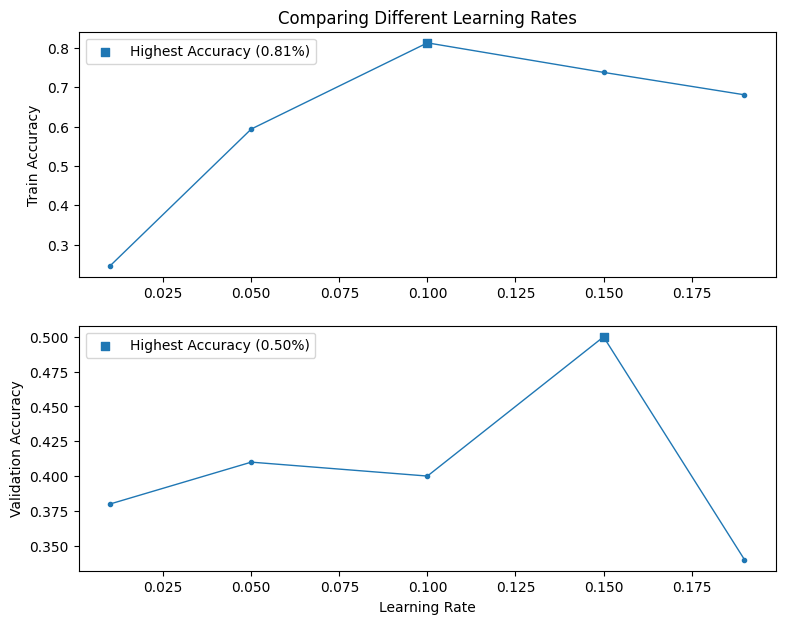

In [13]:
cv_lrs = [0.01, 0.05, 0.1, 0.15, 0.19]
best_accuracies = []

for cv_lr in cv_lrs:
    model = MyAlexNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=cv_lr)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    
    for epoch in range(50):
        
        t_loss, t_accuracy, _ = train_loop(model, cv_train_loader, optimizer, loss_fn=nn.CrossEntropyLoss())
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        v_loss, v_accuracy = test_loop(model, cv_val_loader, loss_fn=nn.CrossEntropyLoss())
    
    print(f"lr = {cv_lr}, train loss: {t_loss:4f}, train acc: {t_accuracy*100:4f}, val acc: {v_accuracy*100:4f}")
    best_accuracies.append((t_accuracy, v_accuracy))
    
    # Free up GPU memory
    #del model
    #torch.cuda.empty_cache()

print("\n")
t_accuracies, v_accuracies = zip(*best_accuracies)

#plot train and val accuracy
plt.figure(figsize=(9,7))
ax1 = plt.subplot(211)
plt.plot(cv_lrs, t_accuracies,  marker='.', linestyle='-', linewidth=1.0)

max_accuracy = max(t_accuracies)
best_lr = cv_lrs[t_accuracies.index(max_accuracy)]
plt.scatter(best_lr, max_accuracy,  marker='s',  label=f'Highest Accuracy ({max_accuracy:.2f}%)')
plt.legend()
plt.title('Comparing Different Learning Rates')
plt.ylabel('Train Accuracy')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(cv_lrs, v_accuracies,  marker='.', linestyle='-', linewidth=1.0)

max_accuracy = max(v_accuracies)
best_lr = cv_lrs[v_accuracies.index(max_accuracy)]
plt.scatter(best_lr, max_accuracy, marker='s', label=f'Highest Accuracy ({max_accuracy:.2f}%)')

plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')

plt.legend()
plt.show()

#### Main Function

In [14]:
results = {} #to log performance metrics

In [15]:
NUM_EPOCHS = 15


def main(model, model_name, mode=None, scheduler =None):
    
    total_params = sum(p.numel() for p in model.parameters())
    
    start_time = time.time()
    train_loss_list = []
    iter_train_list = []
    train_acc_list = []
    
    val_loss_list = []
    val_acc_list = []

    test_acc_list = []

    for epoch in range(0, NUM_EPOCHS):
        print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}\n----------------------")
        torch.cuda.empty_cache()
        
        train_loss, train_accuracy, train_iter_loss = train_loop(model, train_loader, optimizer, loss_fn, verbose=False, mode=mode)
        if scheduler:
            scheduler.step()
        val_loss, val_accuracy = test_loop(model, val_loader, loss_fn)
        _, test_accuracy = test_loop(model, test_loader, loss_fn)

        print(f"Train Loss: {train_loss:>7f} | Train Accuracy: {train_accuracy*100:>3f}% | Val Accuracy: {val_accuracy*100:>3f}% | Test Accuracy: {test_accuracy*100:>3f}%")
        
        #collect train accuracy and loss per epoch and mini batch loss
        train_acc_list.append(train_accuracy*100)
        train_loss_list.append(train_loss)
        iter_train_list.extend(train_iter_loss)
        
        val_loss_list.append(val_loss)
        val_acc_list.append(val_accuracy*100)
        
        test_acc_list.append(test_accuracy*100)
        
        elapsed = (time.time() - start_time)/60
        print(f'Time Elapsed: {elapsed:.2f} min\n')
        

        
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    torch.cuda.empty_cache()
    
    results[model_name] = {
        'train_loss': train_loss_list,
        'train_acc': train_acc_list,
        'train_iter_loss': iter_train_list,
        'val_loss': val_loss_list,
        'val_acc': val_acc_list,
        'test_acc': test_acc_list,
        'training_time': elapsed,
        'total_params': total_params
    }

#### Vanilla AlexNet Training

In [16]:
if __name__ == '__main__':
    model = MyAlexNet().to(device)
    LEARNING_RATE = 0.1
    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

    main(model, "alexnet_vanilla", scheduler=None)

Epoch: 1/15
----------------------
Train Loss: 2.152737 | Train Accuracy: 18.740000% | Val Accuracy: 31.980000% | Test Accuracy: 33.000000%
Time Elapsed: 0.33 min

Epoch: 2/15
----------------------
Train Loss: 1.736777 | Train Accuracy: 35.631111% | Val Accuracy: 41.660000% | Test Accuracy: 42.750000%
Time Elapsed: 0.66 min

Epoch: 3/15
----------------------
Train Loss: 1.498875 | Train Accuracy: 44.637778% | Val Accuracy: 47.400000% | Test Accuracy: 47.650000%
Time Elapsed: 0.97 min

Epoch: 4/15
----------------------
Train Loss: 1.331110 | Train Accuracy: 51.402222% | Val Accuracy: 44.800000% | Test Accuracy: 45.290000%
Time Elapsed: 1.28 min

Epoch: 5/15
----------------------
Train Loss: 1.190093 | Train Accuracy: 57.395556% | Val Accuracy: 59.960000% | Test Accuracy: 60.160000%
Time Elapsed: 1.59 min

Epoch: 6/15
----------------------
Train Loss: 1.047300 | Train Accuracy: 62.500000% | Val Accuracy: 66.560000% | Test Accuracy: 66.980000%
Time Elapsed: 1.89 min

Epoch: 7/15
----

In [17]:
#torch.save(model.state_dict(), 'model_weights.pth')

#### Metrics Plot (Vanilla AlexNet)

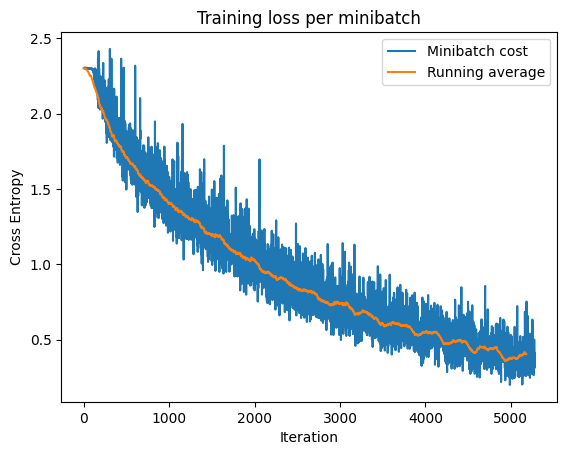

In [18]:
plt.plot(results["alexnet_vanilla"]['train_iter_loss'], label='Minibatch cost')
plt.plot(np.convolve(results["alexnet_vanilla"]['train_iter_loss'],np.ones(100,)/100, mode='valid'),label='Running average')

plt.title("Training loss per minibatch")
plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

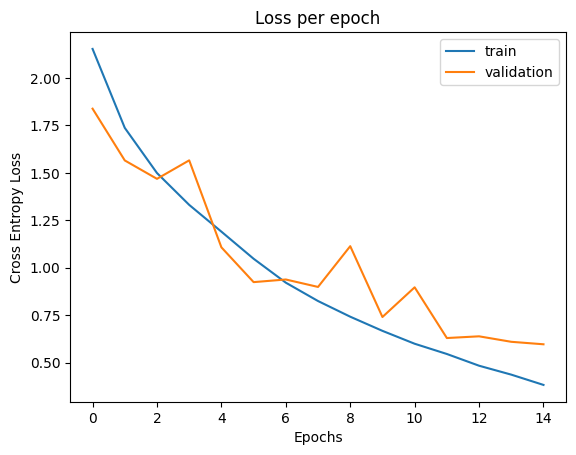

In [19]:
plt.plot(results["alexnet_vanilla"]['train_loss'], label="train")
plt.plot(results["alexnet_vanilla"]['val_loss'], label="validation")

plt.title("Loss per epoch")
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

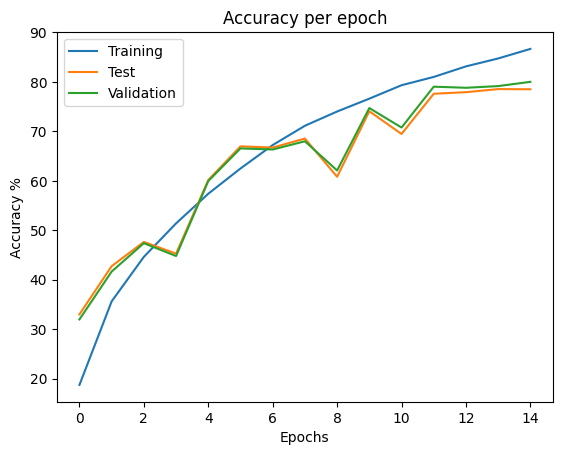

In [20]:
plt.plot(results["alexnet_vanilla"]['train_acc'], label= "Training")
plt.plot(results["alexnet_vanilla"]['test_acc'], label="Test")
plt.plot(results["alexnet_vanilla"]['val_acc'], label="Validation")

plt.title("Accuracy per epoch")
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### 1.2 Overfit and Underfit AlexNet

In [21]:
class ExpMyAlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, mode="over"):
        super().__init__()
        self.flatten = nn.Flatten()

        if mode == "over":
            self.features = nn.Sequential(
                nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(128, 384, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(384, 768, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(768, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
            )
            self.classifier = nn.Sequential(
                nn.Linear(512 * 4 * 4, 8192),
                nn.ReLU(inplace=True),
                nn.Linear(8192, 8192),
                nn.ReLU(inplace=True),
                nn.Linear(8192, num_classes),
            )
        elif mode == "under":
            self.features = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
            )
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(8 * 16 * 16 , 32),
                nn.ReLU(inplace=True),
                nn.Linear(32, num_classes),
            )
        else:
            print("Choose a valid mode")
            
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        logits = self.classifier(x)
        return logits

#### 1.2.1 Underfit AlexNet

In [22]:
if __name__ == '__main__':
    under_model = ExpMyAlexNet(mode="under").to(device)
    LEARNING_RATE = 0.1
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(under_model.parameters(), lr=LEARNING_RATE)
    main(under_model, "alexnet_underfit")

Epoch: 1/15
----------------------
Train Loss: 1.739065 | Train Accuracy: 36.906667% | Val Accuracy: 46.760000% | Test Accuracy: 46.550000%
Time Elapsed: 0.30 min

Epoch: 2/15
----------------------
Train Loss: 1.490528 | Train Accuracy: 46.722222% | Val Accuracy: 50.520000% | Test Accuracy: 51.410000%
Time Elapsed: 0.60 min

Epoch: 3/15
----------------------
Train Loss: 1.411257 | Train Accuracy: 49.971111% | Val Accuracy: 44.000000% | Test Accuracy: 43.940000%
Time Elapsed: 0.91 min

Epoch: 4/15
----------------------
Train Loss: 1.359875 | Train Accuracy: 52.077778% | Val Accuracy: 51.860000% | Test Accuracy: 52.640000%
Time Elapsed: 1.21 min

Epoch: 5/15
----------------------
Train Loss: 1.324222 | Train Accuracy: 53.191111% | Val Accuracy: 52.640000% | Test Accuracy: 53.500000%
Time Elapsed: 1.51 min

Epoch: 6/15
----------------------
Train Loss: 1.292658 | Train Accuracy: 54.246667% | Val Accuracy: 53.140000% | Test Accuracy: 53.410000%
Time Elapsed: 1.82 min

Epoch: 7/15
----

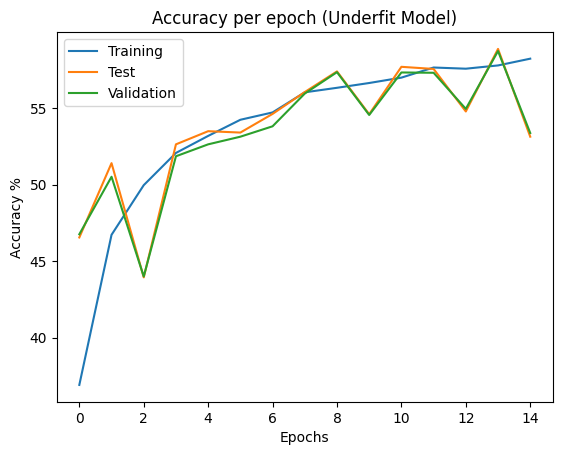

In [23]:
plt.plot(results["alexnet_underfit"]['train_acc'], label= "Training")
plt.plot(results["alexnet_underfit"]['test_acc'], label="Test")
plt.plot(results["alexnet_underfit"]['val_acc'], label="Validation")

plt.title("Accuracy per epoch (Underfit Model)")
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.legend()
plt.show()

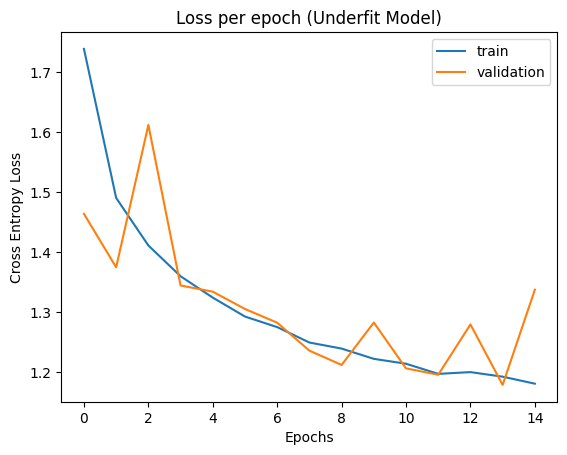

In [24]:
plt.plot(results["alexnet_underfit"]['train_loss'], label="train")
plt.plot(results["alexnet_underfit"]['val_loss'], label="validation")

plt.title("Loss per epoch (Underfit Model)")
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### 1.2.2 Overfit AlexNet

In [25]:
if __name__ == '__main__':
    over_model = ExpMyAlexNet(mode="over").to(device)
    LEARNING_RATE = 0.3
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(over_model.parameters(), lr=LEARNING_RATE)
    main(over_model, "alexnet_overfit")

Epoch: 1/15
----------------------
Train Loss: 2.241542 | Train Accuracy: 15.106667% | Val Accuracy: 25.380000% | Test Accuracy: 24.900000%
Time Elapsed: 0.38 min

Epoch: 2/15
----------------------
Train Loss: 1.856771 | Train Accuracy: 30.862222% | Val Accuracy: 39.260000% | Test Accuracy: 40.340000%
Time Elapsed: 0.76 min

Epoch: 3/15
----------------------
Train Loss: 1.486614 | Train Accuracy: 45.215556% | Val Accuracy: 52.320000% | Test Accuracy: 52.590000%
Time Elapsed: 1.13 min

Epoch: 4/15
----------------------
Train Loss: 1.191769 | Train Accuracy: 57.217778% | Val Accuracy: 62.340000% | Test Accuracy: 61.470000%
Time Elapsed: 1.52 min

Epoch: 5/15
----------------------
Train Loss: 0.939107 | Train Accuracy: 66.884444% | Val Accuracy: 65.200000% | Test Accuracy: 64.850000%
Time Elapsed: 1.88 min

Epoch: 6/15
----------------------
Train Loss: 0.752059 | Train Accuracy: 73.675556% | Val Accuracy: 63.140000% | Test Accuracy: 62.710000%
Time Elapsed: 2.26 min

Epoch: 7/15
----

##### Metrics Plot

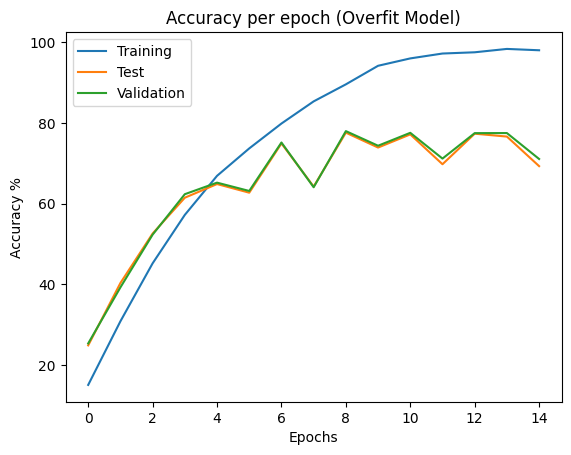

In [26]:
plt.plot(results["alexnet_overfit"]['train_acc'], label= "Training")
plt.plot(results["alexnet_overfit"]['test_acc'], label="Test")
plt.plot(results["alexnet_overfit"]['val_acc'], label="Validation")

plt.title("Accuracy per epoch (Overfit Model)")
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.legend()
plt.show()

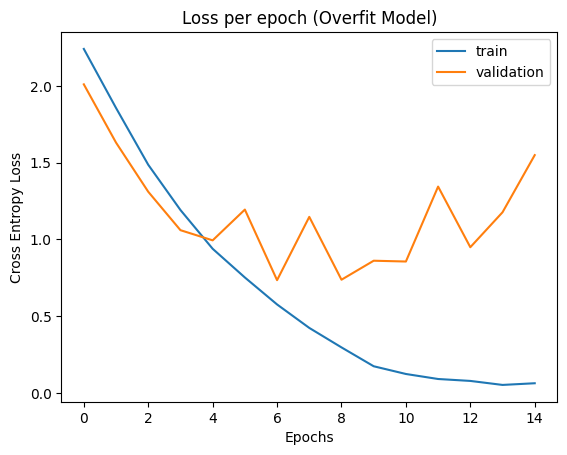

In [27]:
plt.plot(results["alexnet_overfit"]['train_loss'], label="train")
plt.plot(results["alexnet_overfit"]['val_loss'], label="validation")

plt.title("Loss per epoch (Overfit Model)")
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

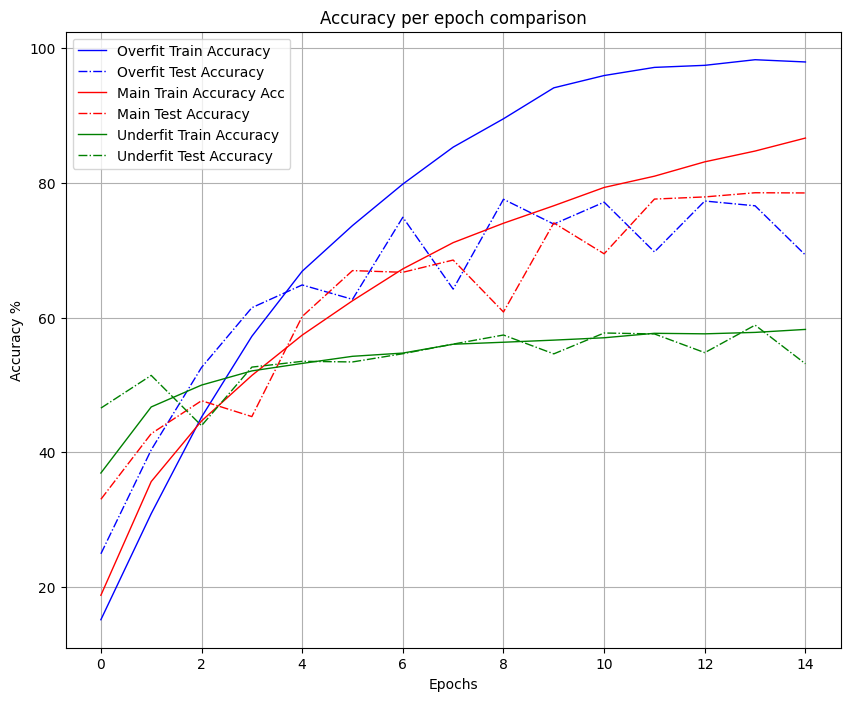

In [28]:
plt.figure(figsize=(10,8))
plt.plot(results["alexnet_overfit"]['train_acc'], 'b-', label= "Overfit Train Accuracy", lw=1)
plt.plot(results["alexnet_overfit"]['test_acc'], 'b-.', label= "Overfit Test Accuracy", lw=1)

plt.plot(results["alexnet_vanilla"]['train_acc'], 'r-', label="Main Train Accuracy Acc", lw=1)
plt.plot(results["alexnet_vanilla"]['test_acc'], 'r-.', label="Main Test Accuracy", lw=1)

plt.plot(results["alexnet_underfit"]['train_acc'], 'g-', label="Underfit Train Accuracy", lw=1)
plt.plot(results["alexnet_underfit"]['test_acc'], 'g-.', label="Underfit Test Accuracy", lw=1)


plt.title("Accuracy per epoch comparison")
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()
plt.show()

### 1.3.1 AlexNet (DropOut)

In [29]:
class DropExpMyAlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, mode="over"):
        super().__init__()
        self.flatten = nn.Flatten()

        if mode == "over":
            self.features = nn.Sequential(
                nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(128, 384, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(384, 768, kernel_size=3, padding=1),
                nn.Dropout(p=0.5),
                nn.ReLU(inplace=True),
                nn.Conv2d(768, 512, kernel_size=3, padding=1),
                nn.Dropout(p=0.5),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
            )
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(512 * 4 * 4, 8192),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5),
                nn.Linear(8192, 8192),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5),
                nn.Linear(8192, num_classes),
            )
        elif mode == "under":
            self.features = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
            )
            self.classifier = nn.Sequential(
                nn.Linear(8 * 16 * 16 , 32),
                nn.ReLU(inplace=True),
                nn.Linear(32, num_classes),
            )
        else:
            print("Choose a valid mode")
            
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        logits = self.classifier(x)
        return logits

In [30]:
if __name__ == '__main__':
    over_model_dropout = DropExpMyAlexNet(mode="over").to(device)
    LEARNING_RATE = 0.3
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(over_model_dropout.parameters(), lr=LEARNING_RATE)
    main(over_model_dropout, "alexnet_overfit_dropout", scheduler=None, mode=None)

Epoch: 1/15
----------------------
Train Loss: 2.236861 | Train Accuracy: 14.473333% | Val Accuracy: 22.000000% | Test Accuracy: 21.840000%
Time Elapsed: 0.37 min

Epoch: 2/15
----------------------
Train Loss: 1.849384 | Train Accuracy: 30.131111% | Val Accuracy: 32.840000% | Test Accuracy: 32.390000%
Time Elapsed: 0.75 min

Epoch: 3/15
----------------------
Train Loss: 1.543433 | Train Accuracy: 43.215556% | Val Accuracy: 44.260000% | Test Accuracy: 44.110000%
Time Elapsed: 1.13 min

Epoch: 4/15
----------------------
Train Loss: 1.302266 | Train Accuracy: 52.857778% | Val Accuracy: 61.240000% | Test Accuracy: 60.660000%
Time Elapsed: 1.48 min

Epoch: 5/15
----------------------
Train Loss: 1.107335 | Train Accuracy: 60.686667% | Val Accuracy: 63.380000% | Test Accuracy: 63.620000%
Time Elapsed: 1.81 min

Epoch: 6/15
----------------------
Train Loss: 0.942064 | Train Accuracy: 67.135556% | Val Accuracy: 65.940000% | Test Accuracy: 66.490000%
Time Elapsed: 2.12 min

Epoch: 7/15
----

In [31]:
if __name__ == '__main__':
    under_model_dropout = DropExpMyAlexNet(mode="under").to(device)
    LEARNING_RATE = 0.15
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(under_model_dropout.parameters(), lr=LEARNING_RATE)
    main(under_model_dropout, "alexnet_underfit_dropout", scheduler=None, mode=None)

Epoch: 1/15
----------------------
Train Loss: 1.738252 | Train Accuracy: 37.613333% | Val Accuracy: 46.200000% | Test Accuracy: 45.440000%
Time Elapsed: 0.30 min

Epoch: 2/15
----------------------
Train Loss: 1.413511 | Train Accuracy: 49.928889% | Val Accuracy: 42.460000% | Test Accuracy: 42.950000%
Time Elapsed: 0.60 min

Epoch: 3/15
----------------------
Train Loss: 1.306734 | Train Accuracy: 53.891111% | Val Accuracy: 54.880000% | Test Accuracy: 54.220000%
Time Elapsed: 0.90 min

Epoch: 4/15
----------------------
Train Loss: 1.221593 | Train Accuracy: 57.053333% | Val Accuracy: 54.360000% | Test Accuracy: 53.770000%
Time Elapsed: 1.21 min

Epoch: 5/15
----------------------
Train Loss: 1.170243 | Train Accuracy: 58.553333% | Val Accuracy: 52.160000% | Test Accuracy: 51.900000%
Time Elapsed: 1.51 min

Epoch: 6/15
----------------------
Train Loss: 1.137635 | Train Accuracy: 59.924444% | Val Accuracy: 53.280000% | Test Accuracy: 52.650000%
Time Elapsed: 1.81 min

Epoch: 7/15
----

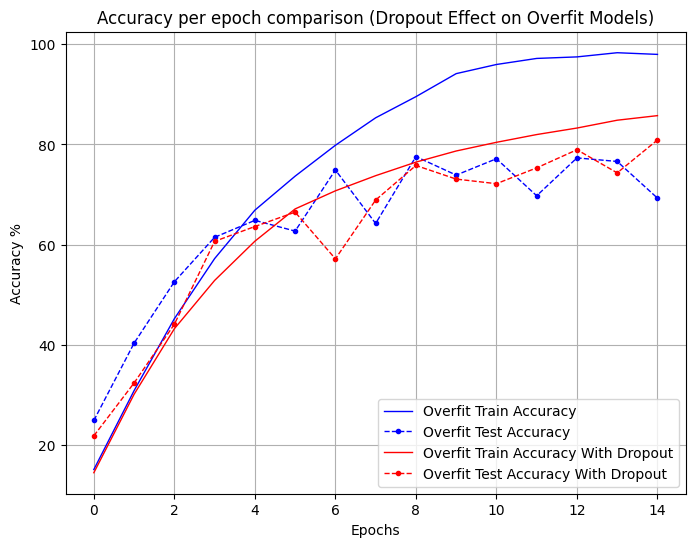

In [32]:
plt.figure(figsize=(8,6))
plt.plot(results["alexnet_overfit"]['train_acc'], 'b-', label= "Overfit Train Accuracy", lw=1)
plt.plot(results["alexnet_overfit"]['test_acc'], 'b--.', label= "Overfit Test Accuracy", lw=1)

plt.plot(results["alexnet_overfit_dropout"]['train_acc'], 'r-', label="Overfit Train Accuracy With Dropout", lw=1)
plt.plot(results["alexnet_overfit_dropout"]['test_acc'], 'r--.', label="Overfit Test Accuracy With Dropout", lw=1)

plt.title("Accuracy per epoch comparison (Dropout Effect on Overfit Models)")
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()
plt.show()

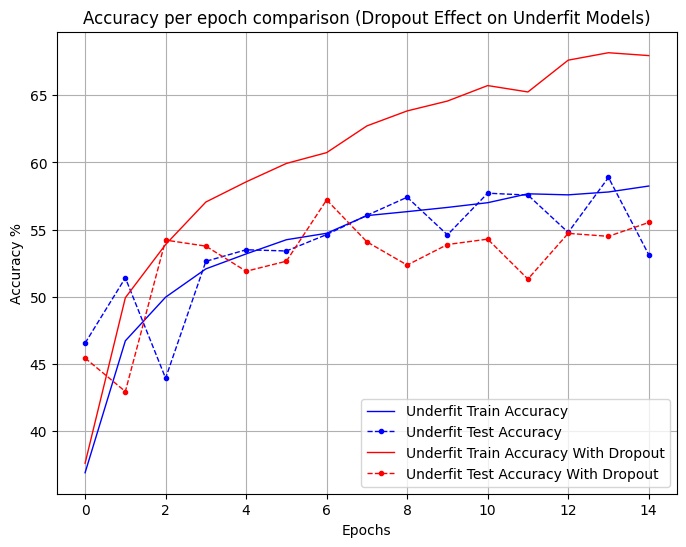

In [33]:
plt.figure(figsize=(8,6))
plt.plot(results["alexnet_underfit"]['train_acc'], 'b-', label= "Underfit Train Accuracy", lw=1)
plt.plot(results["alexnet_underfit"]['test_acc'], 'b--.', label= "Underfit Test Accuracy", lw=1)

plt.plot(results["alexnet_underfit_dropout"]['train_acc'], 'r-', label="Underfit Train Accuracy With Dropout", lw=1)
plt.plot(results["alexnet_underfit_dropout"]['test_acc'], 'r--.', label="Underfit Test Accuracy With Dropout", lw=1)

plt.title("Accuracy per epoch comparison (Dropout Effect on Underfit Models)")
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()
plt.show()

### 1.3.2 AlexNet (SGD momentum = 0.9)

In [34]:
if __name__ == '__main__':
    model_moment = MyAlexNet().to(device)
    LEARNING_RATE = 0.01
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_moment.parameters(), lr=LEARNING_RATE, momentum=0.9)
    
    main(model_moment, "alexnet_momentum", scheduler=None)

Epoch: 1/15
----------------------
Train Loss: 2.144230 | Train Accuracy: 18.606667% | Val Accuracy: 29.160000% | Test Accuracy: 29.630000%
Time Elapsed: 0.32 min

Epoch: 2/15
----------------------
Train Loss: 1.615268 | Train Accuracy: 39.857778% | Val Accuracy: 44.140000% | Test Accuracy: 44.450000%
Time Elapsed: 0.61 min

Epoch: 3/15
----------------------
Train Loss: 1.330017 | Train Accuracy: 51.384444% | Val Accuracy: 56.000000% | Test Accuracy: 55.760000%
Time Elapsed: 0.92 min

Epoch: 4/15
----------------------
Train Loss: 1.120280 | Train Accuracy: 59.615556% | Val Accuracy: 63.900000% | Test Accuracy: 64.540000%
Time Elapsed: 1.22 min

Epoch: 5/15
----------------------
Train Loss: 0.957159 | Train Accuracy: 65.842222% | Val Accuracy: 69.160000% | Test Accuracy: 68.450000%
Time Elapsed: 1.53 min

Epoch: 6/15
----------------------
Train Loss: 0.835042 | Train Accuracy: 70.440000% | Val Accuracy: 69.100000% | Test Accuracy: 68.540000%
Time Elapsed: 1.84 min

Epoch: 7/15
----

#### Metrics

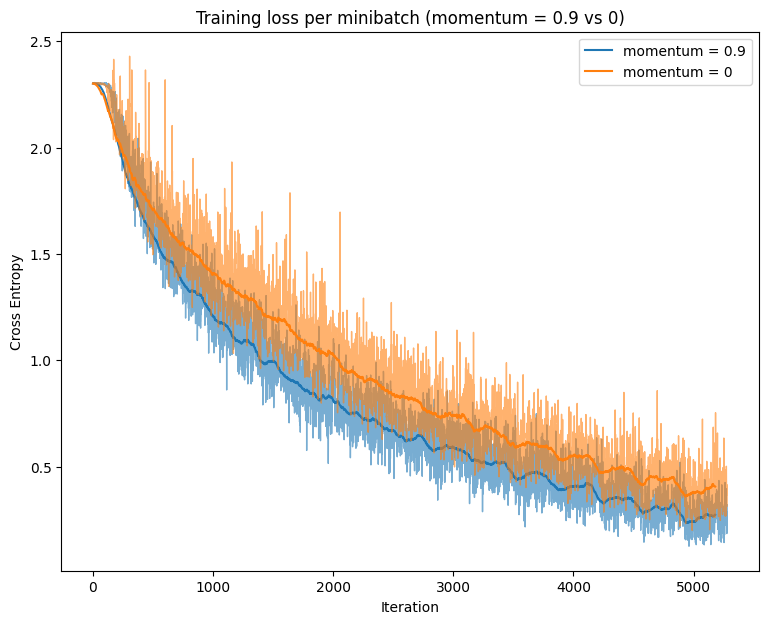

In [35]:
plt.figure(figsize=(9,7))
plt.plot(results["alexnet_momentum"]['train_iter_loss'], alpha = 0.6, lw=1)
plt.plot(np.convolve(results["alexnet_momentum"]['train_iter_loss'],np.ones(100,)/100, mode='valid'), c='tab:blue', label='momentum = 0.9')

plt.plot(results["alexnet_vanilla"]['train_iter_loss'],alpha = 0.6, lw=1)
plt.plot(np.convolve(results["alexnet_vanilla"]['train_iter_loss'],np.ones(100,)/100, mode='valid'), c='tab:orange', label='momentum = 0')

plt.title("Training loss per minibatch (momentum = 0.9 vs 0)")
plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

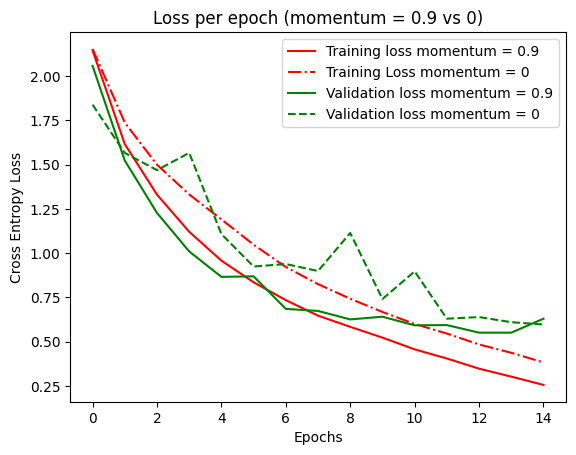

In [36]:
plt.plot(results["alexnet_momentum"]['train_loss'], 'r-', label="Training loss momentum = 0.9")
plt.plot(results["alexnet_vanilla"]['train_loss'], 'r-.', label="Training Loss momentum = 0")
plt.plot(results["alexnet_momentum"]['val_loss'],'g-', label="Validation loss momentum = 0.9")
plt.plot(results["alexnet_vanilla"]['val_loss'], 'g--',label="Validation loss momentum = 0")

plt.title("Loss per epoch (momentum = 0.9 vs 0)")
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

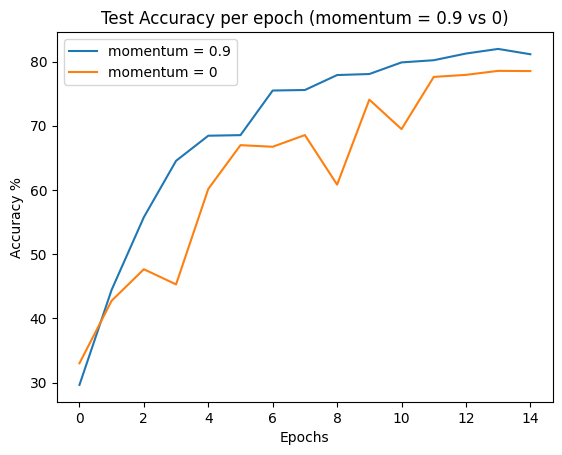

In [37]:
plt.plot(results["alexnet_momentum"]['test_acc'], label="momentum = 0.9")
plt.plot(results["alexnet_vanilla"]['test_acc'], label="momentum = 0")

plt.title("Test Accuracy per epoch (momentum = 0.9 vs 0)")
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## 2.0 Comparing CNN Architectures (GoogLeNet, ResNet, VGG)

### 2.1 ResNet

In [38]:
resnet = models.resnet50(weights=None)

In [39]:
resnet.fc = nn.Linear(2048, 10)
resnet.conv1 = nn.Conv2d(3,64, kernel_size=3, stride=1, padding=1, bias=False)

In [40]:
if __name__ == '__main__':
    resnet.to(device)
    LEARNING_RATE = 0.01
    loss_fn = nn.CrossEntropyLoss()
    WEIGHT_DECAY = 5e-4
    scheduler = MultiStepLR(optimizer, milestones=[9, 12], gamma=0.1)
    optimizer = optim.SGD(resnet.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY, momentum = 0.9)
    
    main(resnet, "resnet", scheduler=scheduler, mode=None)

Epoch: 1/15
----------------------


/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train Loss: 2.037290 | Train Accuracy: 33.360000% | Val Accuracy: 47.860000% | Test Accuracy: 48.710000%
Time Elapsed: 0.36 min

Epoch: 2/15
----------------------
Train Loss: 1.333575 | Train Accuracy: 52.471111% | Val Accuracy: 55.860000% | Test Accuracy: 56.060000%
Time Elapsed: 0.72 min

Epoch: 3/15
----------------------
Train Loss: 1.110327 | Train Accuracy: 61.000000% | Val Accuracy: 60.060000% | Test Accuracy: 60.190000%
Time Elapsed: 1.08 min

Epoch: 4/15
----------------------
Train Loss: 0.924085 | Train Accuracy: 67.375556% | Val Accuracy: 63.220000% | Test Accuracy: 63.460000%
Time Elapsed: 1.46 min

Epoch: 5/15
----------------------
Train Loss: 0.782383 | Train Accuracy: 72.720000% | Val Accuracy: 67.260000% | Test Accuracy: 66.750000%
Time Elapsed: 1.83 min

Epoch: 6/15
----------------------
Train Loss: 0.651106 | Train Accuracy: 77.362222% | Val Accuracy: 66.340000% | Test Accuracy: 66.050000%
Time Elapsed: 2.21 min

Epoch: 7/15
----------------------
Train Loss: 0.53

In [41]:
resnet18 = models.resnet18(weights=None)
resnet18.fc = nn.Linear(512, 10)
resnet18.conv1 = nn.Conv2d(3,64, kernel_size=3, stride=1, padding=1, bias=False)

In [42]:
if __name__ == '__main__':
    resnet18.to(device)
    LEARNING_RATE = 0.01
    loss_fn = nn.CrossEntropyLoss()
    WEIGHT_DECAY = 5e-4
    scheduler = MultiStepLR(optimizer, milestones=[9, 12], gamma=0.1)
    optimizer = optim.SGD(resnet18.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY, momentum = 0.9)
    
    main(resnet18, "resnet18", scheduler=scheduler, mode=None)

Epoch: 1/15
----------------------
Train Loss: 1.363256 | Train Accuracy: 50.793333% | Val Accuracy: 58.440000% | Test Accuracy: 58.480000%
Time Elapsed: 0.35 min

Epoch: 2/15
----------------------
Train Loss: 0.889259 | Train Accuracy: 68.628889% | Val Accuracy: 67.260000% | Test Accuracy: 66.530000%
Time Elapsed: 0.69 min

Epoch: 3/15
----------------------
Train Loss: 0.659598 | Train Accuracy: 76.764444% | Val Accuracy: 69.380000% | Test Accuracy: 68.470000%
Time Elapsed: 1.04 min

Epoch: 4/15
----------------------
Train Loss: 0.484931 | Train Accuracy: 82.991111% | Val Accuracy: 73.540000% | Test Accuracy: 71.940000%
Time Elapsed: 1.39 min

Epoch: 5/15
----------------------
Train Loss: 0.354980 | Train Accuracy: 87.608889% | Val Accuracy: 75.000000% | Test Accuracy: 73.050000%
Time Elapsed: 1.72 min

Epoch: 6/15
----------------------
Train Loss: 0.237154 | Train Accuracy: 91.731111% | Val Accuracy: 73.660000% | Test Accuracy: 74.130000%
Time Elapsed: 2.05 min

Epoch: 7/15
----

### 2.2 GoogeLeNet

In [43]:
googlenet = models.googlenet(weights=None, init_weights=True)

In [44]:
googlenet.fc = nn.Linear(1024, 10)
googlenet.aux1.fc2 = nn.Linear(1024, 10)
googlenet.aux2.fc2 = nn.Linear(1024, 10)
googlenet.conv1.conv = nn.Conv2d(3,64, kernel_size=3, stride=1, padding=1, bias=False)

In [45]:
if __name__ == '__main__':
    googlenet.to(device)
    LEARNING_RATE = 0.01
    loss_fn = nn.CrossEntropyLoss()
    WEIGHT_DECAY = 5e-4
    scheduler = MultiStepLR(optimizer, milestones=[9, 12], gamma=0.1)
    optimizer = optim.SGD(googlenet.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY, momentum = 0.9)
        
    main(googlenet, "googlenet", mode = "inception", scheduler=scheduler)

Epoch: 1/15
----------------------
Train Loss: 2.416137 | Train Accuracy: 44.693333% | Val Accuracy: 58.460000% | Test Accuracy: 58.920000%
Time Elapsed: 0.37 min

Epoch: 2/15
----------------------
Train Loss: 1.627035 | Train Accuracy: 64.000000% | Val Accuracy: 64.800000% | Test Accuracy: 64.490000%
Time Elapsed: 0.74 min

Epoch: 3/15
----------------------
Train Loss: 1.276442 | Train Accuracy: 72.086667% | Val Accuracy: 72.400000% | Test Accuracy: 71.370000%
Time Elapsed: 1.11 min

Epoch: 4/15
----------------------
Train Loss: 1.026535 | Train Accuracy: 77.846667% | Val Accuracy: 76.520000% | Test Accuracy: 76.690000%
Time Elapsed: 1.50 min

Epoch: 5/15
----------------------
Train Loss: 0.852621 | Train Accuracy: 81.840000% | Val Accuracy: 77.960000% | Test Accuracy: 77.800000%
Time Elapsed: 1.87 min

Epoch: 6/15
----------------------
Train Loss: 0.725899 | Train Accuracy: 84.368889% | Val Accuracy: 79.460000% | Test Accuracy: 79.300000%
Time Elapsed: 2.25 min

Epoch: 7/15
----

### 2.2 VGG

In [46]:
vggnet = models.vgg16_bn(weights=None)

In [47]:
vggnet.classifier.pop(6)
vggnet.classifier.append(nn.Linear(4096, 10, bias=True))

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [48]:
if __name__ == '__main__':
    vggnet.to(device)
    LEARNING_RATE = 0.01
    loss_fn = nn.CrossEntropyLoss()
    WEIGHT_DECAY = 5e-4
    scheduler = MultiStepLR(optimizer, milestones=[9, 12], gamma=0.1)
    optimizer = optim.SGD(vggnet.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY, momentum = 0.9)
        
    main(vggnet, "vggnet", scheduler=scheduler, mode=None)

Epoch: 1/15
----------------------
Train Loss: 1.724708 | Train Accuracy: 36.846667% | Val Accuracy: 50.940000% | Test Accuracy: 51.100000%
Time Elapsed: 0.38 min

Epoch: 2/15
----------------------
Train Loss: 1.201406 | Train Accuracy: 57.860000% | Val Accuracy: 61.000000% | Test Accuracy: 61.200000%
Time Elapsed: 0.77 min

Epoch: 3/15
----------------------
Train Loss: 0.936206 | Train Accuracy: 68.064444% | Val Accuracy: 68.420000% | Test Accuracy: 68.550000%
Time Elapsed: 1.13 min

Epoch: 4/15
----------------------
Train Loss: 0.735241 | Train Accuracy: 75.364444% | Val Accuracy: 74.700000% | Test Accuracy: 73.950000%
Time Elapsed: 1.49 min

Epoch: 5/15
----------------------
Train Loss: 0.606244 | Train Accuracy: 80.008889% | Val Accuracy: 75.540000% | Test Accuracy: 75.400000%
Time Elapsed: 1.86 min

Epoch: 6/15
----------------------
Train Loss: 0.495409 | Train Accuracy: 83.715556% | Val Accuracy: 76.060000% | Test Accuracy: 75.960000%
Time Elapsed: 2.23 min

Epoch: 7/15
----

### 2.3 CNN COMPARISON 

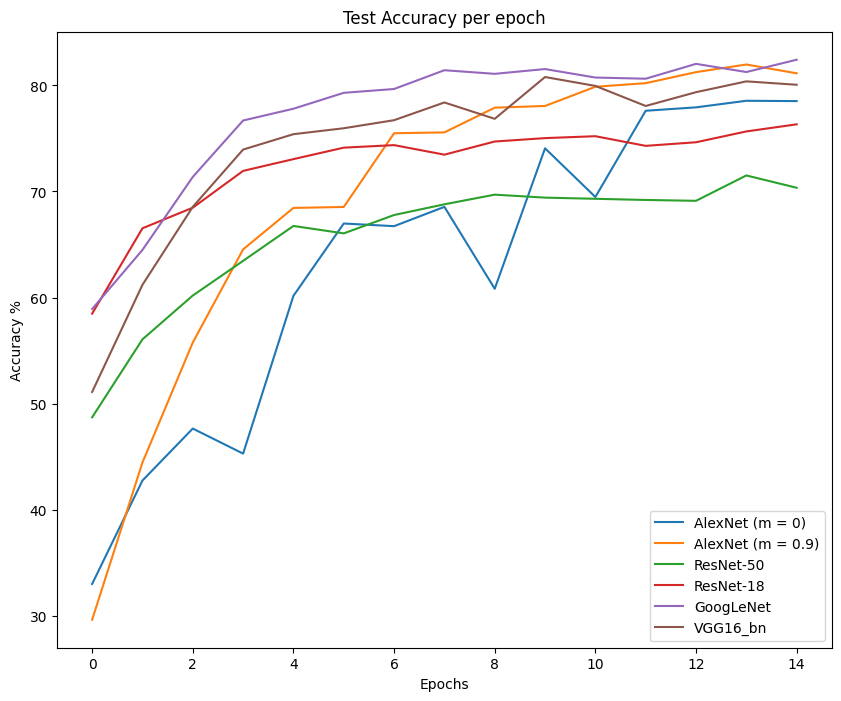

In [65]:
plt.figure(figsize=(10,8))
plt.plot(results["alexnet_vanilla"]['test_acc'], label= "AlexNet (m = 0)")
plt.plot(results["alexnet_momentum"]['test_acc'], label= "AlexNet (m = 0.9)")
plt.plot(results["resnet"]['test_acc'], label="ResNet-50")
plt.plot(results["resnet18"]['test_acc'], label="ResNet-18")
plt.plot(results["googlenet"]['test_acc'], label="GoogLeNet")
plt.plot(results["vggnet"]['test_acc'], label="VGG16_bn")

plt.title("Test Accuracy per epoch")
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.legend()
plt.show()

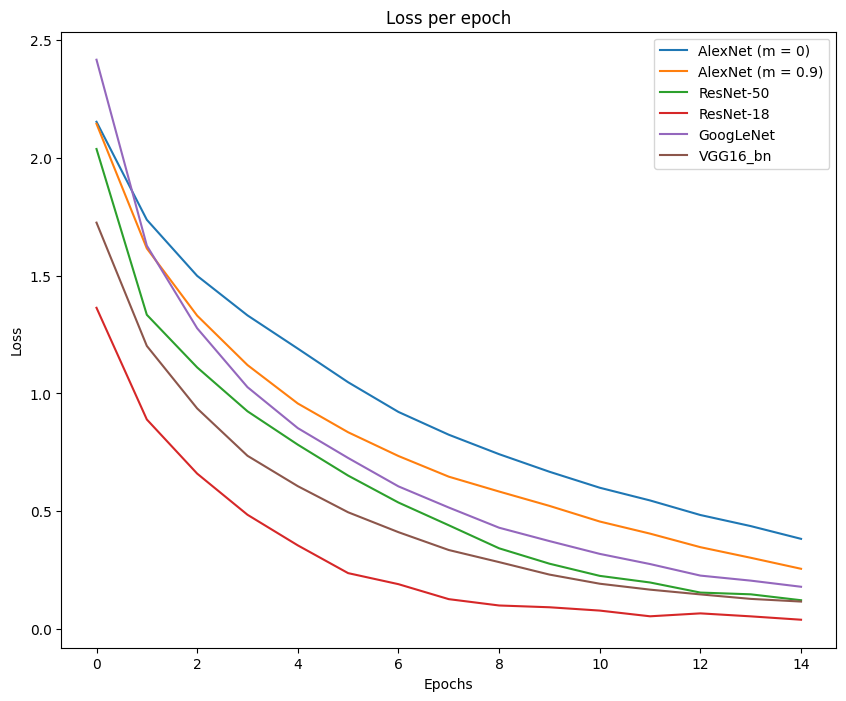

In [66]:
plt.figure(figsize=(10,8))
plt.plot(results["alexnet_vanilla"]['train_loss'], label= "AlexNet (m = 0)")
plt.plot(results["alexnet_momentum"]['train_loss'], label= "AlexNet (m = 0.9)")
plt.plot(results["resnet"]['train_loss'], label="ResNet-50")
plt.plot(results["resnet18"]['train_loss'], label="ResNet-18")
plt.plot(results["googlenet"]['train_loss'], label="GoogLeNet")
plt.plot(results["vggnet"]['train_loss'], label="VGG16_bn")

plt.title("Loss per epoch")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

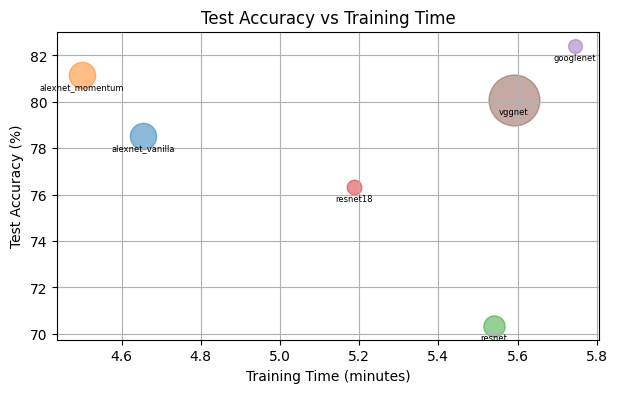

In [51]:
no_plot = ['alexnet_underfit', 'alexnet_overfit', 'alexnet_overfit_dropout', 'alexnet_underfit_dropout']
param_scaling_factor = 1e-5  # Adjust for marker size
plt.figure(figsize=(7,4))

for m, obj in results.items():
    if m not in no_plot:
        # Plot the scatter point
        plt.scatter(
            obj['training_time'],          # x-axis: training time
            obj['test_acc'][-1],           # y-axis: final test accuracy
            s=obj['total_params']*param_scaling_factor,  # marker size proportional to params
            marker="o",
            alpha=0.5,
            label=m  # label for legend
        )
        
        # Add text annotation for each bubble (placing it slightly offset from the center)
        plt.text(
            obj['training_time'],          # x-coordinate
            obj['test_acc'][-1]-0.7,           # y-coordinate
            m,                             # text label (model name)
            fontsize=6,                    # adjust font size
            ha='center',                   # horizontal alignment (center text on bubble)
            va='bottom'                    # vertical alignment (place text slightly above)
        )
    
# Set the title and axis labels
plt.title("Test Accuracy vs Training Time")
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Training Time (minutes)')
plt.grid(True)
#plt.legend()
plt.show()

In [63]:
for m, obj in results.items():
    print(f"{m:<25}: Train Accuracy: {obj['train_acc'][-1]:>6.2f}% \t| Test Accuracy: {obj['test_acc'][-1]:>6.2f}% | Training Time: {obj['training_time']:>7.2f}mins | Number Of Parameters: {obj['total_params']:>11,}")


alexnet_vanilla          : Train Accuracy:  86.68% 	| Test Accuracy:  78.52% | Training Time:    4.65mins | Number Of Parameters:  35,855,178
alexnet_underfit         : Train Accuracy:  58.24% 	| Test Accuracy:  53.14% | Training Time:    4.52mins | Number Of Parameters:      66,122
alexnet_overfit          : Train Accuracy:  97.98% 	| Test Accuracy:  69.29% | Training Time:    5.63mins | Number Of Parameters: 143,316,618
alexnet_overfit_dropout  : Train Accuracy:  85.76% 	| Test Accuracy:  80.90% | Training Time:    5.37mins | Number Of Parameters: 143,316,618
alexnet_underfit_dropout : Train Accuracy:  67.95% 	| Test Accuracy:  55.53% | Training Time:    4.46mins | Number Of Parameters:      66,122
alexnet_momentum         : Train Accuracy:  90.94% 	| Test Accuracy:  81.14% | Training Time:    4.50mins | Number Of Parameters:  35,855,178
resnet                   : Train Accuracy:  95.76% 	| Test Accuracy:  70.35% | Training Time:    5.54mins | Number Of Parameters:  23,520,842
resnet